<a href="https://colab.research.google.com/github/bullbeary-bots/Colabs/blob/main/k_means_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [1]:
!pip install kneed

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data extraction and management
import pandas as pd
import numpy as np
import yfinance as yf

# Feature engineering
from sklearn.preprocessing import StandardScaler

# Machine learning
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator

# Cointegration and statistics
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

# Visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

%matplotlib inline

### Data Extraction

In [21]:
# Set data extraction parameters
start_date = '2017-01-01'
end_date = '2023-01-01'
file_name = 'raw_data_etf.csv'
file_name_coint = 'raw_data_coint_pairs.csv'
load_existing = False
load_coint_pairs = False

In [4]:
def get_nasdaq_symbols():
    # URL to NASDAQ symbol list (requires periodic checking if URL changes)
    url = "ftp://ftp.nasdaqtrader.com/SymbolDirectory/nasdaqlisted.txt"
    symbols = pd.read_csv(url, sep="|")  # The file is pipe-delimited
    return symbols[:-1]  # Remove the last line which contains metadata

# Example Usage
symbols = get_nasdaq_symbols()
print(symbols.head())


  Symbol                                      Security Name Market Category  \
0   AACG  ATA Creativity Global - American Depositary Sh...               G   
1   AADI               Aadi Bioscience, Inc. - Common Stock               S   
2   AADR                AdvisorShares Dorsey Wright ADR ETF               G   
3    AAL       American Airlines Group, Inc. - Common Stock               Q   
4   AAME       Atlantic American Corporation - Common Stock               G   

  Test Issue Financial Status  Round Lot Size ETF NextShares  
0          N                D           100.0   N          N  
1          N                N           100.0   N          N  
2          N                N           100.0   Y          N  
3          N                N           100.0   N          N  
4          N                N           100.0   N          N  


In [5]:
symbols = get_nasdaq_symbols()
# G = NDAQ global market
symbols = symbols[(symbols['ETF']=='Y') & (symbols['Market Category'] == 'G')]
symbols = list(symbols.Symbol.values)

In [6]:
data = yf.download(symbols[:5], start=start_date,
                   end=end_date, multi_level_index=False)['Close']

data.describe()

[*********************100%***********************]  5 of 5 completed


Ticker,AADR,AAPB,AAPD,AAPU,AAVM
count,1510.000000,100.000000,100.000000,101.000000,1426.000000
mean,50.193456,17.213735,24.996038,17.787019,23.279895
std,6.858172,2.560124,1.578701,2.205598,1.905977
min,32.105461,12.338435,21.689184,13.501757,18.088755
25%,44.892806,15.509851,24.207782,16.305719,21.982246
50%,49.646866,16.685964,24.872163,17.381008,22.990515
75%,55.023488,18.542208,26.109545,18.926695,24.952794
max,64.935051,23.201145,28.787395,22.848064,27.706312


In [7]:
# Get new or load existing data
if not load_existing:
  data = yf.download(symbols, start=start_date,
                     end=end_date, multi_level_index=False)['Close']
  data.to_csv(file_name)
else:
  data = pd.read_csv(file_name, index_col=0)

[*********************100%***********************]  783 of 783 completed
ERROR:yfinance:
321 Failed downloads:
ERROR:yfinance:['QQQP', 'QOWZ', 'MYCJ', 'PQJL', 'TSLW', 'QQQY', 'MKAM', 'DUKX', 'NIXT', 'PCMM', 'SLVR', 'FDCF', 'SMHX', 'PTEC', 'CCNR', 'BDGS', 'BUFC', 'NFXS', 'USCL', 'MNTL', 'OCTA', 'AGIX', 'INRO', 'IBTO', 'SMCX', 'LITP', 'AIRL', 'QBIG', 'NVDD', 'BRKU', 'IBGA', 'AGMI', 'FEAT', 'TLTM', 'SPYB', 'COPP', 'AIPI', 'EYEG', 'CA', 'TEKX', 'NATO', 'QNXT', 'TSDD', 'NCPB', 'DYFI', 'METU', 'CPLS', 'MUU', 'FDIF', 'NEWZ', 'AOHY', 'MEDX', 'VCRB', 'ZZZ', 'SFLO', 'CORO', 'DVSP', 'DUKH', 'BSMW', 'PBQQ', 'XAIX', 'WISE', 'PLTD', 'PEPS', 'VFLO', 'QSML', 'ZTEN', 'METD', 'MSTX', 'SWP', 'QQQG', 'SETM', 'FMED', 'IBTP', 'UPGR', 'ESN', 'QBUF', 'EGGQ', 'RUNN', 'XBIL', 'PTIR', 'TPLS', 'PSWD', 'FIVY', 'BTFX', 'PQAP', 'BRTR', 'LCDS', 'ABCS', 'LGRO', 'SEIS', 'TSMG', 'SMCO', 'SPYQ', 'SMCF', 'NFXL', 'BRKD', 'XFIX', 'DFGP', 'JPEF', 'UNIY', 'UBRL', 'FEPI', 'EHLS', 'JMID', 'HYBI', 'USRD', 'CEPI', 'DYNI', 'QQQW',

OSError: Cannot save file into a non-existent directory: 'data'

In [8]:
data.head()

Ticker,AADR,AAPB,AAPD,AAPU,AAVM,AAXJ,ABCS,ACWI,ACWX,AGIX,...,XMAG,XOVR,XT,YLDE,YQQQ,ZAP,ZTEN,ZTRE,ZTWO,ZZZ
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,37.707664,NaN,NaN,NaN,NaN,47.736553,NaN,51.166954,32.655445,NaN,...,NaN,NaN,24.948755,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,38.356693,NaN,NaN,NaN,NaN,48.209881,NaN,51.604576,33.018364,NaN,...,NaN,NaN,25.273006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,38.768044,NaN,NaN,NaN,NaN,48.889744,NaN,51.801926,33.300648,NaN,...,NaN,NaN,25.356384,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,38.640064,NaN,NaN,NaN,NaN,48.648769,NaN,51.810516,33.163536,NaN,...,NaN,NaN,25.402708,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09,38.777184,NaN,NaN,NaN,NaN,48.691807,NaN,51.690384,33.115154,NaN,...,NaN,NaN,25.464781,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
data.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-17',
               ...
               '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21',
               '2022-12-22', '2022-12-23', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', name='Date', length=1510, freq=None)

In [10]:
data.dropna(inplace=True, axis=1)
print(f'Shape: {data.shape}')
print(f'Null values: ', data.isna().sum().sum())
data.head()

Shape: (1510, 251)
Null values:  0


Ticker,AADR,AAXJ,ACWI,ACWX,AGNG,AGZD,AIA,AIRR,ALTY,ANGL,...,VTHR,VTIP,VTWG,VTWO,VTWV,VWOB,VXUS,VYMI,WOOD,XT
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,37.707664,47.736553,51.166954,32.655445,14.394272,17.777311,39.586166,23.407642,7.907802,18.961021,...,91.358246,38.726654,106.038139,48.944199,89.443665,52.389263,36.275669,40.721455,46.727726,24.948755
2017-01-04,38.356693,48.209881,51.604576,33.018364,14.394272,17.817881,39.797676,23.752871,8.018955,19.020103,...,92.408264,38.742405,108.264435,49.678261,90.796898,52.597973,36.676044,41.134365,47.144466,25.273006
2017-01-05,38.768044,48.889744,51.801926,33.300648,14.394272,17.814205,40.288372,23.349613,8.078764,19.066040,...,92.240593,38.789673,107.430748,49.182877,89.572968,52.934662,36.950794,41.533035,47.109745,25.356384
2017-01-06,38.640064,48.648769,51.810516,33.163536,14.394272,17.799442,40.119167,23.349613,8.156571,19.085724,...,92.478828,38.726654,106.881294,48.975716,89.090263,52.786522,36.872303,41.312325,47.109745,25.402708
2017-01-09,38.777184,48.691807,51.690384,33.115154,14.394272,17.755180,40.229149,22.857836,8.104171,19.098858,...,92.161171,38.750278,106.814972,48.646965,88.012848,52.921204,36.801640,41.198437,46.805870,25.464781


### Feature Engineering

In [11]:
# Create dataframe with returns and volatility information
df_returns = pd.DataFrame(
    data.pct_change().mean()*252,
    columns=['Returns']
)

df_returns['Volatility'] = data.pct_change().std()*np.sqrt(252)
df_returns.head()

,Returns,Volatility
Ticker,,
AADR,0.062724,0.231310
AAXJ,0.066947,0.212982
ACWI,0.096282,0.188448
ACWX,0.063054,0.186369
AGNG,0.114860,0.188770


In [12]:
# Scale features
scaler = StandardScaler()
scaler = scaler.fit_transform(df_returns)
scaled_data = pd.DataFrame(scaler, columns=df_returns.columns, index=df_returns.index)

df_scaled = scaled_data
df_scaled.head()

,Returns,Volatility
Ticker,,
AADR,-0.246106,0.217582
AAXJ,-0.184531,0.031536
ACWI,0.243166,-0.217507
ACWX,-0.241300,-0.238606
AGNG,0.514023,-0.214236


### K-Means Clustering

In [13]:
# Find the optimum number of clusters
X = df_scaled.copy()
K = range(1, 15)
distortions = []

for k in K:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(X)
  distortions.append(kmeans.inertia_)

kl = KneeLocator(K, distortions, curve='convex', direction='decreasing')
c = kl.elbow

print(f'Optimal number of clusters: {c}')

Optimal number of clusters: 4


In [14]:
# Fit the K-Means model
k_means = KMeans(n_clusters=c)
k_means.fit(X)

prediction = k_means.predict(df_scaled)

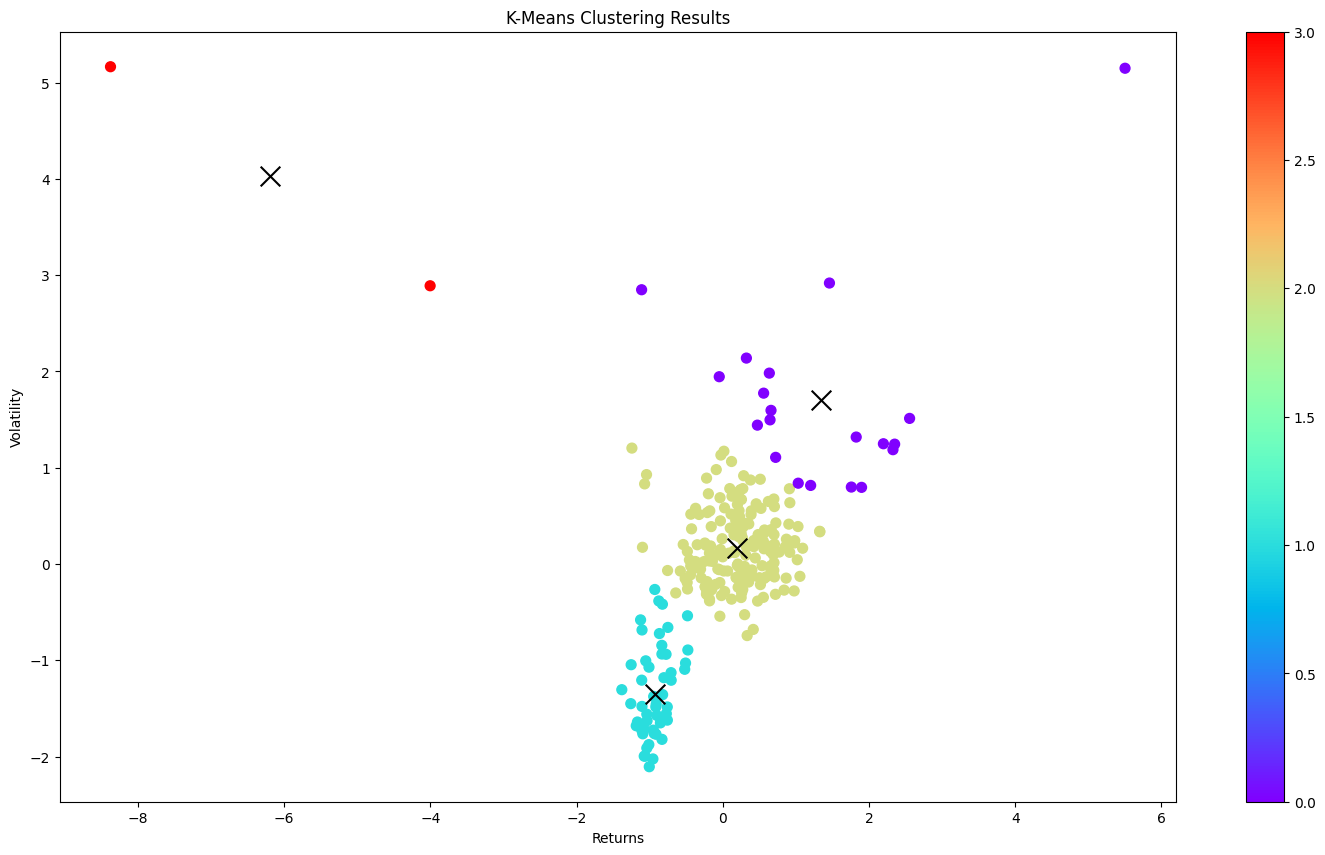

In [15]:
# Show results
centroids = k_means.cluster_centers_

fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=k_means.labels_,
                     s=50, cmap='rainbow', label=X.index)
ax.set_title('K-Means Clustering Results')
ax.set_xlabel('Returns')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=200, label='Centroids')


In [16]:
# Return the series
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())

clustered_series = clustered_series[clustered_series != -1]
clustered_series[:15]

,0
Ticker,
AADR,2
AAXJ,2
ACWI,2
ACWX,2
AGNG,2
AGZD,1
AIA,2
AIRR,2
ALTY,2


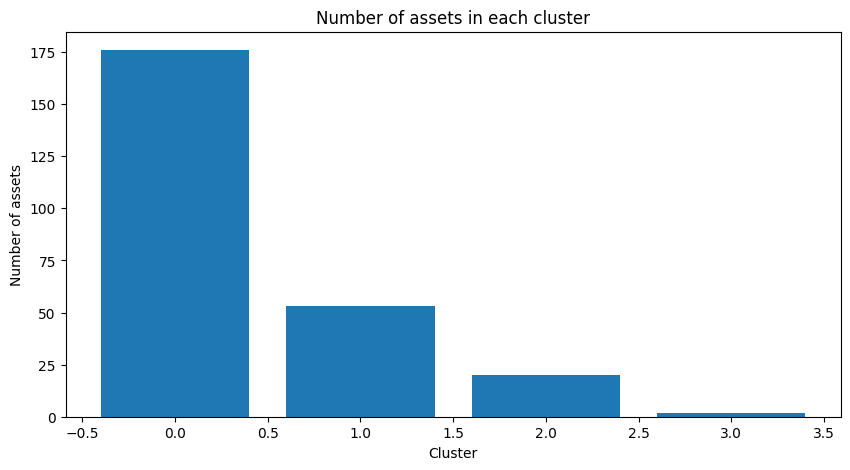

In [17]:
# View number by cluster
plt.figure(figsize=(10,5))
plt.bar(range(len(clustered_series.value_counts())), clustered_series.value_counts())
plt.xlabel('Cluster')
plt.ylabel('Number of assets')
plt.title('Number of assets in each cluster')
plt.show()

In [18]:
# Remove items if preferred
clusters_clean = clustered_series[clustered_series < 3]
print(f'Feature number previous: {len(clustered_series)}')
print(f'Feature number current: {len(clusters_clean)}')

Feature number previous: 251
Feature number current: 249


### Calculate Cointegration

In [19]:
# Calculate cointegration
def calculate_cointegration(series_1, series_2):
  coint_flag = 0
  coint_res = coint(series_1, series_2)
  coint_t = coint_res[0]
  p_value = coint_res[1]
  critical_value = coint_res[2][1]
  model = sm.OLS(series_1, series_2).fit()
  hedge_ratio = model.params[0]
  residuals = model.resid

  if p_value < 0.05 and coint_t < critical_value:
    coint_flag = 1

  return coint_flag, hedge_ratio

In [22]:
# Loop through and calculate cointegrated pairs
tested_pairs = []
cointegrated_pairs = []

if not load_coint_pairs:
  for base_asset in clusters_clean.index:
    base_label = clusters_clean[base_asset]

    for compare_asset in clusters_clean.index:
      compare_label = clusters_clean[compare_asset]

      test_pair = base_asset + compare_asset
      test_pair = ''.join(sorted(test_pair))

      is_tested = test_pair in tested_pairs
      tested_pairs.append(test_pair)

      if compare_asset != base_asset and base_label == compare_label and not is_tested:
        series_1 = data[base_asset].values.astype(float)
        series_2 = data[compare_asset].values.astype(float)

        coint_flag, _ = calculate_cointegration(series_1, series_2)

        if coint_flag == 1:
          cointegrated_pairs.append({'base_asset': base_asset,
                                     'compare_asset': compare_asset,
                                     'label': base_label})

  df_coint = pd.DataFrame(cointegrated_pairs).sort_values(by='label')
  df_coint.to_csv(file_name_coint)
else:
  coint_df = pd.read_csv(file_name_coint)

In [23]:
df_coint.head()

,base_asset,compare_asset,label
195,EWZS,QCLN,0
192,EWZS,PTF,0
213,FBZ,PXI,0
212,FBZ,PTH,0
422,ICLN,QMOM,0


### TSNE Plot for Visualization

In [24]:
# Get unique list of cointegrated assets
coint_assets = [df_coint['base_asset'].values]
coint_assets.append(df_coint['compare_asset'].values)
coint_unique_assets = np.unique(coint_assets)
coint_unique_assets[:5]

array(['AADR', 'AAXJ', 'ACWI', 'ACWX', 'AGNG'], dtype=object)

In [25]:
# Get TSNE only returns and volatility
df_TSNE = df_scaled.copy()
df_TSNE = df_TSNE[df_TSNE.index.isin(coint_unique_assets)]
df_TSNE.head()

,Returns,Volatility
Ticker,,
AADR,-0.246106,0.217582
AAXJ,-0.184531,0.031536
ACWI,0.243166,-0.217507
ACWX,-0.241300,-0.238606
AGNG,0.514023,-0.214236


In [26]:
# Compute our TSNE
X_tsne = TSNE(learning_rate=30, n_jobs=-1, perplexity=5).fit_transform(df_TSNE)
X_tsne[:5]

array([[  5.804364  ,  22.227253  ],
       [ -0.08492187,  21.758165  ],
       [-14.170463  ,  -9.458245  ],
       [-19.995552  ,  16.78361   ],
       [-11.581911  , -25.03427   ]], dtype=float32)

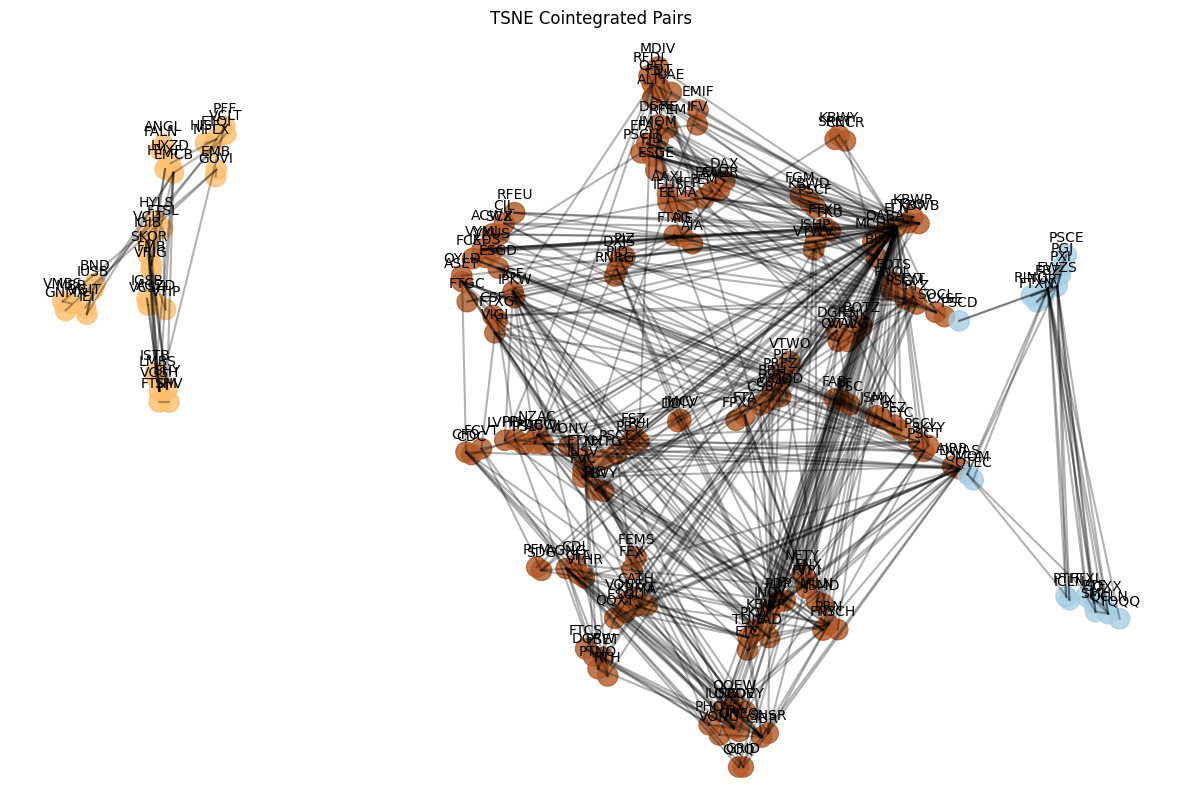

In [29]:
# Preview TSNE
in_pairs_series = clustered_series.loc[coint_unique_assets]
plt.figure(1, figsize=(15,10))
plt.clf()
plt.axis('off')

for index, pair in df_coint.iterrows():
  ticker1 = pair[0]
  loc1 = df_TSNE.index.get_loc(pair[0])
  x1, y1 = X_tsne[loc1, :]

  ticker2 = pair[1]
  loc2 = df_TSNE.index.get_loc(pair[1])
  x2, y2 = X_tsne[loc2, :]
  plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=215, alpha=0.8,
            c=in_pairs_series.values, cmap=cm.Paired)

plt.title('TSNE Cointegrated Pairs')

# Show TSNE plot
for x, y, name in zip(X_tsne[:, 0], X_tsne[:, 1], df_TSNE.index):
  label = name
  plt.annotate(label, (x, y), textcoords='offset points', xytext=(0, 10), ha='center')

plt.show();

### Review a Pair

In [41]:
chosen_pair = df_coint.iloc[26]

asset_1 = chosen_pair.base_asset
asset_2 = chosen_pair.compare_asset

print(f'Asset 1: {asset_1}')
print(f'Asset 2: {asset_2}')

Asset 1: QCLN
Asset 2: SMH


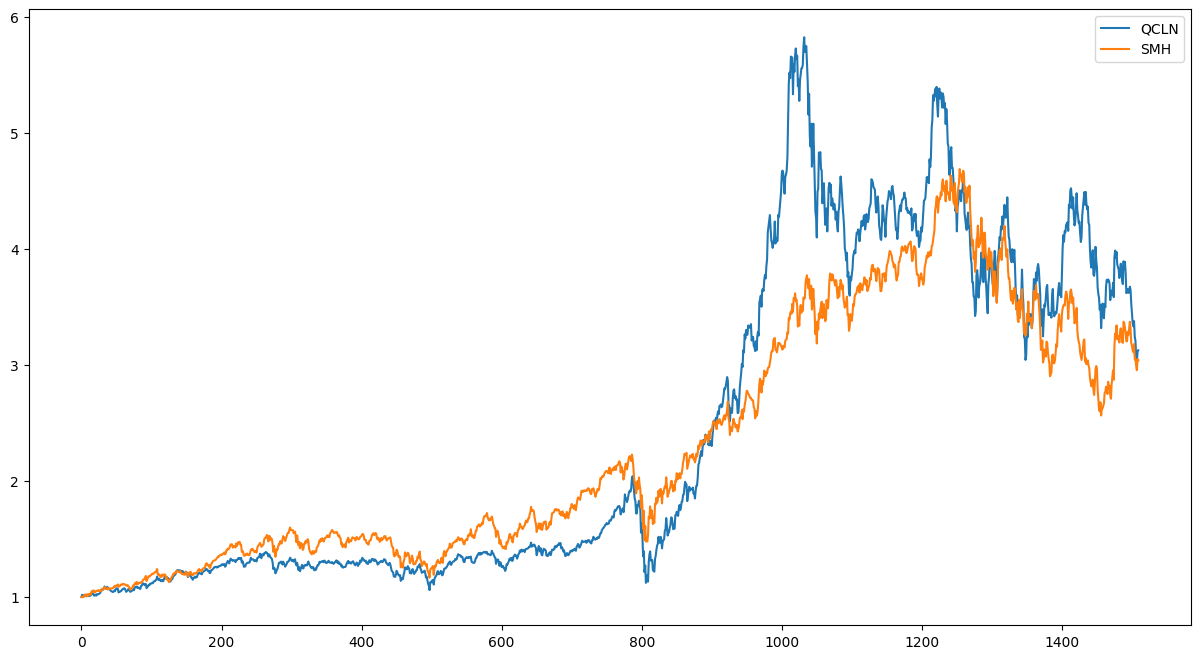

In [42]:
asset_1_values = data[asset_1].values / data[asset_1].iloc[0].item()
asset_2_values = data[asset_2].values / data[asset_2].iloc[0].item()

plt.figure(1, figsize=(15,8))
plt.plot(asset_1_values, label=asset_1)
plt.plot(asset_2_values, label=asset_2)
plt.legend()
plt.show();

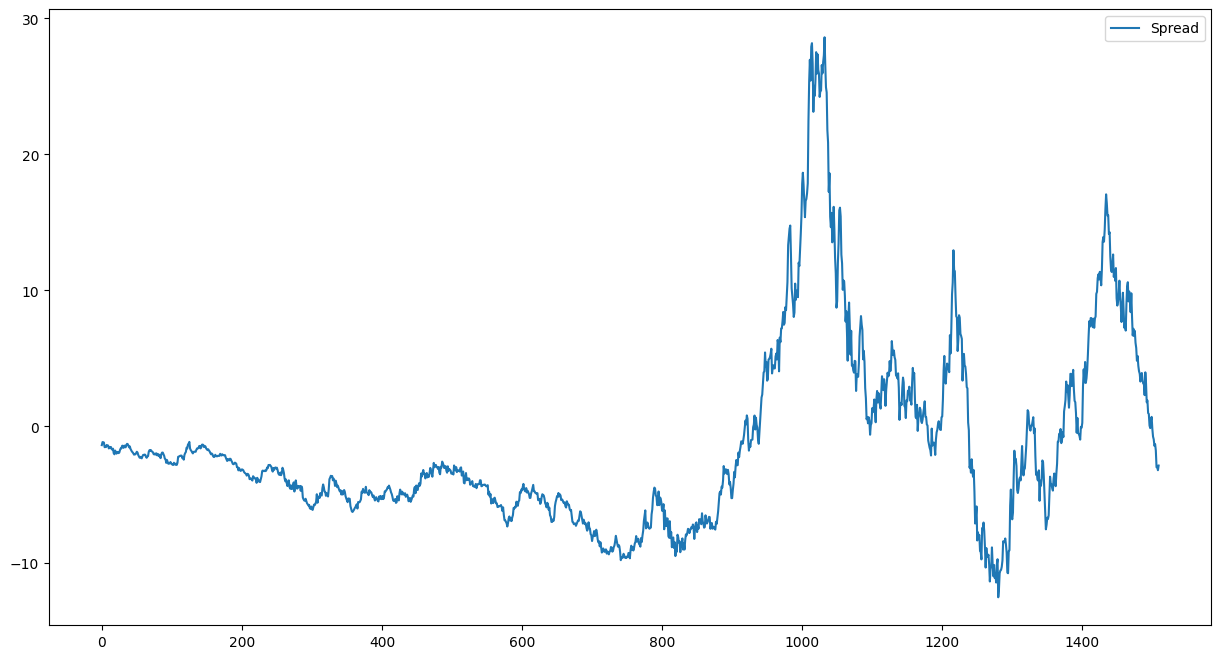

In [43]:
# Plot the spread
series_1 = data[asset_1].values.astype(float)
series_2 = data[asset_2].values.astype(float)

coint_flag, hedge_ratio = calculate_cointegration(series_1, series_2)
spread = series_1 - hedge_ratio * series_2

plt.figure(1, figsize=(15,8))
plt.plot(spread, label='Spread')
plt.legend()
plt.show();

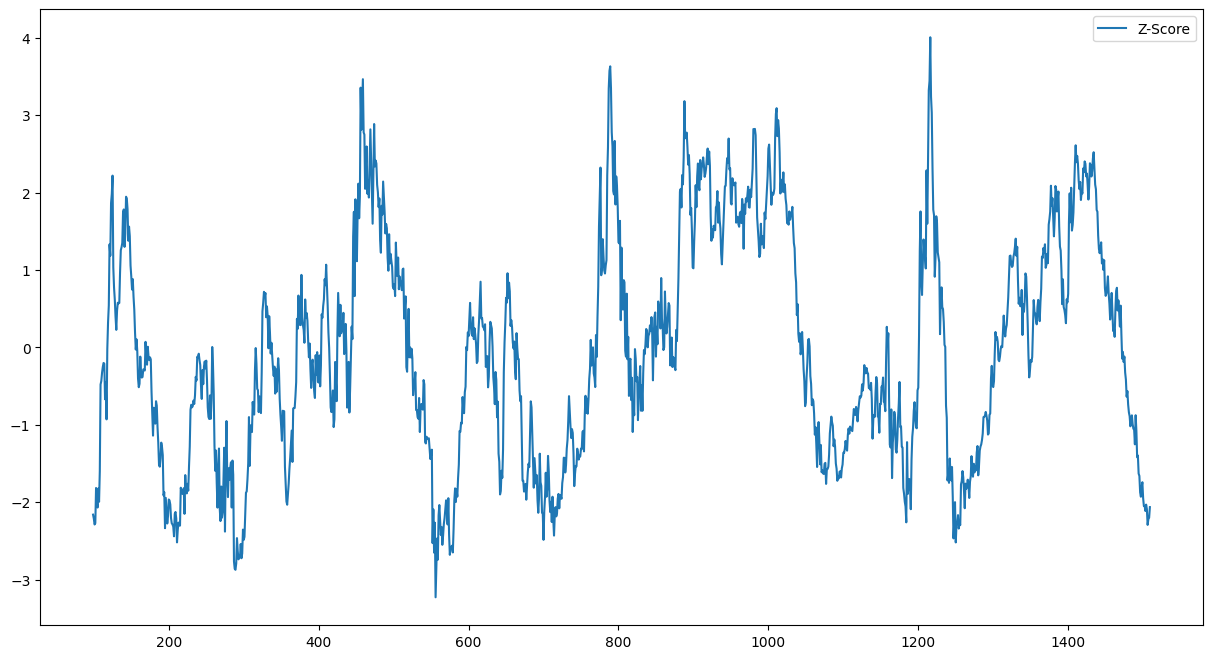

In [44]:
# Plot the Z-score
window = 100
spread_series = pd.Series(spread)
mean = spread_series.rolling(center=False, window=window).mean()
std = spread_series.rolling(center=False, window=window).std()
x = spread_series.rolling(center=False, window=1).mean()
z_score = (x - mean) / std

plt.figure(1, figsize=(15,8))
plt.plot(z_score, label='Z-Score')
plt.legend()
plt.show();